In [1]:

# !git clone --recursive https://github.com/NVlabs/nvdiffrast
# !git clone --recursive https://github.com/graphdeco-inria/gaussian-splatting
# %pwd

# %pip install torch torchvision torchaudio plyfile tqdm opencv-contrib-python matplotlib ninja pandas scipy 
# %cd  /home/julfy/Documents/5th_term/cv/homework2/nvdiffrast
# %pip install .

# %cd /home/julfy/Documents/5th_term/cv/homework2/gaussian-splatting
# %pip install --no-build-isolation ./submodules/diff-gaussian-rasterization
# %pip install --no-build-isolation ./submodules/simple-knn
# %cd ../



In [2]:
%load_ext autoreload
%autoreload 2
import torch

print(torch.cuda.is_available())

import numpy as np
import cv2
import matplotlib.pyplot as plt

from meshwarp import MeshWarper

True


In [3]:
meshwarper = MeshWarper()

W1007 17:48:17.445000 4953 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1007 17:48:17.445000 4953 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


CUDA device available. Using cuda:0 for warping.


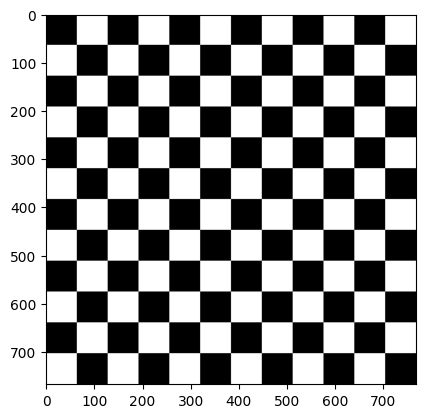

In [4]:
def create_checkerboard(rows, cols, square_size=50):
    # Create checkerboard pattern
    checkerboard = np.kron([[0, 1] * (cols // 2), [1, 0] * (cols // 2)] * (rows // 2),
                           np.ones((square_size, square_size)))
    
    # Normalize to 0-255 grayscale
    checkerboard = (checkerboard * 255).astype(np.uint8)
    grid_points = np.stack(
        np.meshgrid(
            np.arange(cols + 1), 
            np.arange(rows + 1)
        ),
        axis=-1
    ).reshape(-1, 2) * square_size
    return checkerboard, grid_points


def homogenize(pts):
    return np.concatenate([pts, np.ones((pts.shape[0], 1), dtype=pts.dtype)], axis=1)

img, grid_pts = create_checkerboard(12, 12, 64)
plt.imshow(img, cmap="gray")

## Apply linear transform using meshwarp

In [5]:
img, grid_pts = create_checkerboard(12, 12, 64)
H, W = img.shape

# define 2D homogenious transformation 
theta = np.deg2rad(10)
A = np.array([
    [np.cos(theta), -np.sin(theta), 1.],
    [np.sin(theta), np.cos(theta), 0],
    [0.0, 0.0, 1]
])

# warp with opencv
img_warped_opencv = cv2.warpPerspective(img, A, (W, H))

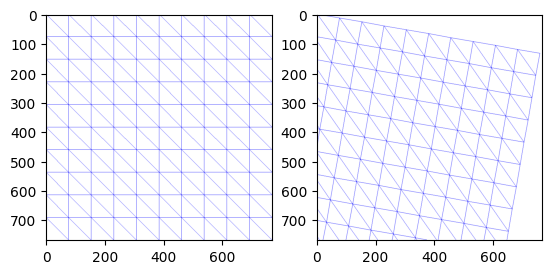

In [6]:
# define source and target grid
grid_src, grid_faces = meshwarper.build_meshgrid(img_width=W, img_height=H, grid_rows=10, grid_cols=10)
grid_dst = homogenize(grid_src) @ A.T
grid_dst = grid_dst[:, :2] / grid_dst[:, 2:]

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(meshwarper.draw_meshgrid(grid_src, grid_faces, W, H))
axes[1].imshow(meshwarper.draw_meshgrid(grid_dst, grid_faces, W, H))

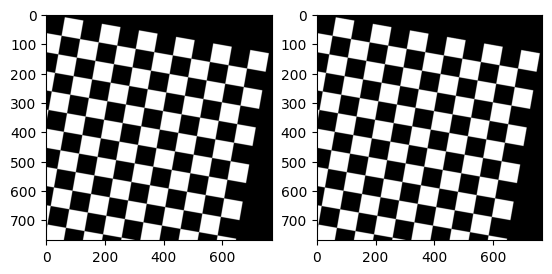

In [7]:
# interpolate with meshwarper
img_warped_meshwarp = meshwarper.warp_grid(img, grid_src, grid_dst, grid_faces, (W, H))

# compare results
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(img_warped_opencv, cmap="gray")
axes[1].imshow(img_warped_meshwarp, cmap="gray")

## Apply non-linear transform using mesh-warp

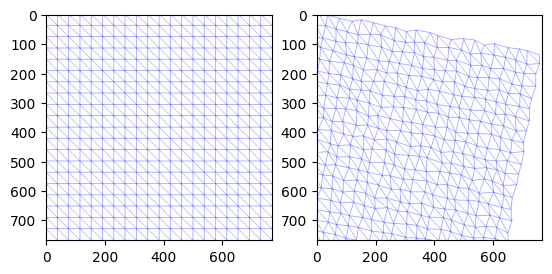

In [8]:
# define source and target grid
grid_src, grid_faces = meshwarper.build_meshgrid(img_width=W, img_height=H, grid_rows=20, grid_cols=20)
grid_dst = homogenize(grid_src) @ A.T
grid_dst = grid_dst[:, :2] / grid_dst[:, 2:]
# add random perturbations
grid_dst = grid_dst + np.random.randint(-7, 7, size=grid_dst.shape)


fig, axes = plt.subplots(ncols=2)
axes[0].imshow(meshwarper.draw_meshgrid(grid_src, grid_faces, W, H))
axes[1].imshow(meshwarper.draw_meshgrid(grid_dst, grid_faces, W, H))

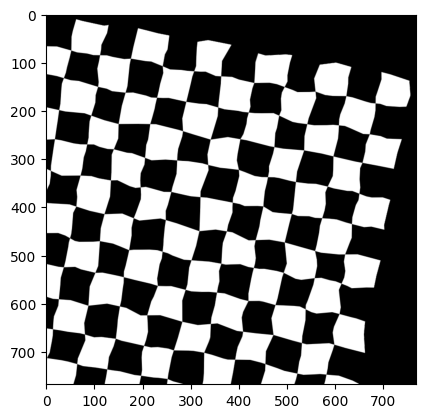

In [9]:
# interpolate with meshwarper
img_warped_meshwarp = meshwarper.warp_grid(img, grid_src, grid_dst, grid_faces, (W, H))
plt.imshow(img_warped_meshwarp, cmap="gray")